In [141]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from sklearn.svm import LinearSVC
from helper import generate_data, shuffleArraysInUnison
from cvxopt import matrix, solvers
from itertools import product
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.misc import imsave
import os
%matplotlib inline

In [142]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [143]:
def subsetData(images, labels, subset, label_dict):
    X = []
    Y = []
    for i in xrange(len(images)):
        label = np.argmax(labels[i])
        if label in subset:
            label = label_dict[label]
            X.append(images[i])
            Y.append(label)
    return np.array(X), np.array(Y)

Pick data that hopefully isn't that seperable, subset it so we're doing linear classification

In [147]:
chosenLabels = set([3,8])
label_dict = {3: -1, 8: 1}
X_train, Y_train = subsetData(mnist.train.images, 
                              mnist.train.labels,
                              chosenLabels, 
                              label_dict)

X_test, Y_test = subsetData(mnist.test.images, 
                            mnist.test.labels,
                            chosenLabels, 
                            label_dict)

X_train, Y_train, _ = shuffleArraysInUnison(X_train, Y_train)
X_test, Y_test, _ = shuffleArraysInUnison(X_test, Y_test)

Train a couple of linear models

In [162]:
models = [LinearSVC(C=5), 
          LinearSVC(loss='hinge', C=.1), 
          LinearSVC(loss='hinge', C=.01)]

In [194]:
X_test.shape

(1984, 784)

In [163]:
for i, model in enumerate(models):
    lb, ub = i * 1000, (i + 1) * 1000
    model.fit(X_train[lb: ub], Y_train[lb: ub])
    print "Model, Accuracy on Test Set"
    print i, model.score(X_test, Y_test)
    print 

Model, Accuracy on Test Set
0 0.941532258065

Model, Accuracy on Test Set
1 0.959677419355

Model, Accuracy on Test Set
2 0.96875



In [164]:
# def subsetCorrect(num_pts, X, Y, models):
#     num_selected = 0
#     num_models = len(models)
#     resX = []
#     resY = []
#     for i in xrange(len(X)):
#         allCorrect = sum([model.score(X[i:i+1], Y[i:i+1]) for model in models]) == num_models
#         if allCorrect:
#             resX.append(X[i])
#             resY.append(Y[i])
#             num_selected += 1
#         if num_selected == num_pts:
#             break
#     if num_selected < num_pts:
#         print "Not enough points were correctly predicted by all models"
#     return np.array(resX), np.array(resY)

In [165]:
evalX, evalY = generate_data(300, X_test, Y_test, models)

Select points that are correctly classified by all the models

In [166]:
[model.score(evalX, evalY) for model in models]

[1.0, 1.0, 1.0]

In [167]:
def computeDistsToPlanes(models, X, Y):
    dists = []
    min_max = []
    num_models = len(models)
    num_points = len(X)
    norms = [np.linalg.norm(model.coef_) for model in models]
    for i in xrange(num_points):
        d = []
        for j in xrange(num_models):    
            # the reshaping happens so sklearn doesn't complain
            isCorrect = models[j].predict(X[i].reshape(1,-1))[0] == Y[i] 
            if isCorrect:
                d.append(abs((np.dot(models[j].coef_, X[i]) + models[j].intercept_)) / norms[j])
            else:
                d.append(np.nan)
        min_max.append((min(d), max(d)))
        dists.append(d)
    return np.array(dists).reshape(num_points, num_models), np.array(min_max).reshape(num_points, 2)

In [168]:
dists, min_max = computeDistsToPlanes(models, evalX, evalY)

In [171]:
print np.mean(dists, axis=0)

[ 0.66828733  0.95834482  1.43564241]


Evaluates the loss function in a particular region on $n$ dimensional space as determined by the signs list (what side of each hyperplane)

In [172]:
def tryRegionBinary(models, signs, x, delta=1e-11):
    P = matrix(np.identity(x.shape[0]))
    q = matrix(np.zeros(x.shape[0]))
    h = []
    G = []
    num_models = len(models)
    for i in xrange(num_models):
        coef, intercept = models[i].coef_, models[i].intercept_
        ineq_val  = -1.0 * delta + signs[i] * (np.dot(coef, x) + intercept) 
        h.append(ineq_val[0])
        G.append(-1.0 * signs[i] * coef.reshape(-1,))   
    h = matrix(h)
    G = matrix(np.array(G))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h)
    if sol['status'] == 'optimal':
        v = np.array(sol['x']).reshape(-1,)
        perturbed_x = np.array(x + v).reshape(1, -1)
        is_desired_sign = [models[i].predict(perturbed_x)[0] == signs[i] for i in xrange(num_models)]
        if sum(is_desired_sign) == num_models:
            return v
        else:
            return tryRegionBinary(models, signs, x, delta * 1.5)
    else:
        return None

In [173]:
test = 14
print evalY[test]
print dists[test]

1
[ 0.72845398  0.75716875  1.23775079]


In [174]:
# the labels that you specify for the region should match the labels predicted by the models
sol = tryRegionBinary(models, [-1, -1, -1], evalX[test])
print np.linalg.norm(sol)
for model in models:
    print model.predict(evalX[test].reshape(1,-1) + sol)[0]

1.2663893147
-1
-1
-1


Tries all $2^n$ possible regions of space to find the maximum value of the function while respecting the constraint that the noise vector $||v|| < \alpha $

In [175]:
def findExampleBinary(weights, models, x, y, alpha):
    candidates = []
    
    # we should only take into consideration models that we could feasibly trickm
    dists, _ = computeDistsToPlanes(models, x.reshape(1, -1), y.reshape(1, -1))
    feasible_models = [models[i] for i in xrange(len(models)) if dists[0][i] < alpha]
    
    num_models = len(feasible_models)
    # can't trick anything
    if num_models == 0:
        return np.zeros(x.shape)
    
    rel_weights = np.array([weights[i] for i in xrange(len(models)) if dists[0][i] < alpha])
    
    signs_values = []
    for signs in product([-1.0, 1.0], repeat=num_models): # iterate over all possible regions
        is_misclassified = np.equal(-1.0 * y * np.ones(num_models), signs) # y = -1, or 1
        value = np.dot(is_misclassified, rel_weights)
        signs_values.append((signs, value))
    
    values = sorted(set([value for signs, value in signs_values]), reverse=True)
    for value in values:
        feasible_candidates = []
        for signs in [sign for sign, val in signs_values if val == value]:
            v = tryRegionBinary(feasible_models, signs, x)
            if v is not None:
                norm = np.linalg.norm(v)
                if norm <= alpha:
                    feasible_candidates.append((v, norm))
        # amongst those with the max value, return the one with the minimum norm
        if feasible_candidates:
            # break out of the loop since we have already found the optimal answer
            return min(feasible_candidates, key=lambda x: x[1])[0]

Finds adversarial noise vectors for each data point

In [176]:
v = findExampleBinary(np.array([0.2, 0.2, 0.6]), models, X_test[0], Y_test[0], 5)

In [177]:
print np.linalg.norm(v)
for model in models:
    print model.predict(X_test[0].reshape(1,-1) + v)[0]

0.72178468127
-1
-1
-1


In [178]:
def Oracle(weights, models, X, Y, alpha, findExample):
    return np.array([findExample(weights, models, x, y, alpha) for x, y in zip(X,Y)])

Gets the costs of each model 

In [179]:
def evaluateCosts(models, V, X, Y):
    return np.array([1 - model.score(X + V, Y) for model in models])

In [180]:
def runMWU(models, T, X, Y, alpha, findExample, epsilon=None):
    
    num_models = len(models)
    
    if epsilon is None:
        delta = np.sqrt(4 * np.log(num_models) / float(T))
        epsilon = delta / 2.0
    else:
        delta = 2.0 * epsilon

    
    print "Running MWU for {} Iterations with Epsilon {}\n".format(T, epsilon)

    print "Guaranteed to be within {} of the minimax value \n".format(delta)
    
    loss_history = []
    costs = []
    max_acc_history = []
    v = []
    w = []
    
    w.append(np.ones(num_models) / num_models)

    for t in xrange(T):
        print "Iteration ", t
        print 
        start_time = time.time()
        
        v_t = Oracle(w[t], models, X, Y, alpha, findExample)
        v.append(v_t)
        
        cost_t = evaluateCosts(models, v_t, X, Y)
        costs.append(cost_t)
        
        print "Shape of costs matrix", np.array(costs).shape
        avg_acc = np.mean((1 - np.array(costs)), axis=0)  
        max_acc = max(avg_acc)
        max_acc_history.append(max_acc)
        
        loss = np.dot(w[t], cost_t)
    
        print "Weights, ", w[t], sum(w[t])
        print "Maximum (Average) Accuracy of Classifier ", max_acc
        print "Cost (Before Noise), ", np.array([1 - model.score(X, Y) for model in models])
        print "Cost (After Noise), ", cost_t
        print "Loss, ", loss
        
        loss_history.append(loss)
        
        new_w = np.copy(w[t])
        
        # penalize experts
        for i in xrange(num_models):
            new_w[i] *= (1.0 - epsilon) ** cost_t[i]
        
        # renormalize weights
        w_sum = new_w.sum()
        for i in xrange(num_models - 1):
            new_w[i] = new_w[i] / w_sum
        new_w[-1] = 1.0 - new_w[:-1].sum()
        
        w.append(new_w)
        
        print
        print "time spent ", time.time() - start_time
        print
        
    return w, v, loss_history, max_acc_history

In [181]:
dists, minmax = computeDistsToPlanes(models, evalX, evalY)

In [182]:
# confirm that these are all points that are correctly predicted by all the models
[model.score(evalX, evalY) for model in models]

[1.0, 1.0, 1.0]

In [183]:
minmax.shape

(300, 2)

In [185]:
np.mean(dists, axis=0)

array([ 0.66828733,  0.95834482,  1.43564241])

In [186]:
res = runMWU(models, 100, evalX, evalY, .95, findExampleBinary)

Running MWU for 100 Iterations with Epsilon 0.104814707397

Guaranteed to be within 0.209629414794 of the minimax value 

Iteration  0

Shape of costs matrix (1, 3)
Weights,  [ 0.33333333  0.33333333  0.33333333] 1.0
Maximum (Average) Accuracy of Classifier  0.77
Cost (Before Noise),  [ 0.  0.  0.]
Cost (After Noise),  [ 0.78333333  0.45        0.23      ]
Loss,  0.487777777778

time spent  117.765130043

Iteration  1

Shape of costs matrix (2, 3)
Weights,  [ 0.32249938  0.33462463  0.34287598] 1.0
Maximum (Average) Accuracy of Classifier  0.765
Cost (Before Noise),  [ 0.  0.  0.]
Cost (After Noise),  [ 0.73666667  0.48666667  0.24      ]
Loss,  0.482715437281

time spent  118.608344078

Iteration  2

Shape of costs matrix (3, 3)
Weights,  [ 0.31347868  0.33439424  0.35212708] 1.0
Maximum (Average) Accuracy of Classifier  0.763333333333
Cost (Before Noise),  [ 0.  0.  0.]
Cost (After Noise),  [ 0.73666667  0.48666667  0.24      ]
Loss,  0.478178323894

time spent  116.379616022

Iterat

In [187]:
w, v, loss_history, max_acc_history = res

In [188]:
exp_dir = "binary_oracle2"
if not os.path.exists(exp_dir):
    os.mkdir(exp_dir)

In [189]:
w, v, loss_history, max_acc_history = np.array(w), np.array(v), np.array(loss_history), np.array(max_acc_history)

In [190]:
np.save(exp_dir+"/w.npy", w)
np.save(exp_dir+"/v.npy", v)
np.save(exp_dir+"/loss_history.npy", loss_history)
np.save(exp_dir+"/max_acc_history.npy", max_acc_history)

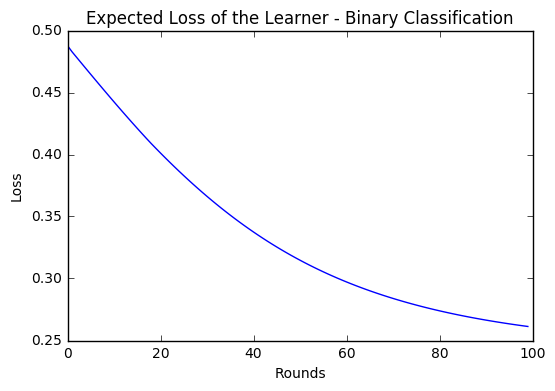

In [191]:
plt.title("Expected Loss of the Learner - Binary Classification")
plt.ylabel("Loss")
plt.xlabel("Rounds")
plt.plot(range(len(loss_history)), loss_history)

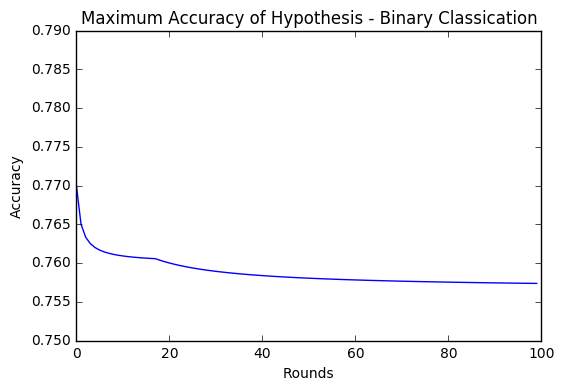

In [197]:
plt.title("Maximum Accuracy of Hypothesis - Binary Classication")
plt.ylabel("Accuracy")
plt.ylim((.75,.79))
plt.xlabel("Rounds")
plt.plot(range(len(max_acc_history)), max_acc_history)

In [ ]:
def selectImage(i, evalX, v):
    images = []
    originalImage = evalX[i].reshape(28,28)
    images.append(originalImage)
    for j in xrange(len(v)):
        images.append(v[j][i].reshape(28,28) + originalImage)
    return images

In [ ]:
images = selectImage(0, evalX, v)

In [ ]:
i =20
plt.imshow(evalX[0].reshape(28,28) + v[i][0].reshape(28,28))